In [3]:
#Load all necessary qiskit and generic libraries

from qiskit import Aer, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools.visualization import circuit_drawer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import circuit_drawer
from qiskit import execute
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline


#Initliaze Simulator
from qiskit import BasicAer
backend = BasicAer.get_backend('statevector_simulator')


In [4]:
def binaryToPhase(binary):
    binary=list(binary[::-1])
    length = len(binary)
    res=0
    
    for i in range(length):
        digit=int(binary.pop())
        if digit==1:
            res=res+pow(2,i)  
    return res

In [5]:
#Function for calling the EigsQpe with minimal values and default most of the values

def create_eigs(matrix, num_ancillae, negative_evals, evo_time=None):
    ne_qfts = [None, None]
    if negative_evals:
        num_ancillae += 1
        ne_qfts = [QFT(num_ancillae - 1), QFT(num_ancillae - 1).inverse()]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_ancillae).inverse(),
                   num_time_slices=1,
                   num_ancillae=num_ancillae,
                   expansion_mode='trotter',
                   expansion_order=1,
                   evo_time=evo_time,
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)


In [6]:
def process_results(circuit,scale,nqbit,cdict,plothist=True):
    
    ndict={}
    
    for kval in cdict.keys():
        nkey=kval[1:]
        ndict[nkey]=cdict[kval]
    
    print('\nCounts:',ndict)
    print('\nActual Eigen Value from Circuit:')
    
    for kval in ndict.keys():
        theta=binaryToPhase(kval)
        
        eigen=(2*np.pi*theta)/((2**nqbit)*scale)
        print('Binary:',kval,' Corresponding Eigen Value:',eigen)
        
    return ndict,circuit

In [11]:
def execute_eigs(matrix,nqubits,negativeEigen):
    #Initialize circuit
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)
    
    # State preparation
    qc.x(q[0])
    qc.h(q[0])
    
    e,v=np.linalg.eig(matrix)
    print('Expected Eigen Values:',e)
    
    eigs = create_eigs(matrix, nqubits, negativeEigen)
    num_q, num_a = eigs.get_register_sizes()
    qc += eigs.construct_circuit("circuit", q)
    
    qc.draw(fold=-1)
    
    print(eigs._num_ancillae)
    print(eigs._operator.paulis)
    print(sum([abs(p[0]) for p in eigs._operator.paulis]))
    
    scale=eigs.get_scaling()
    
    print(scale)
    
    result = execute(qc,backend).result()
    counts = result.get_counts()

    res=sorted(counts.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
    
    
    rdict=dict(res)
   
    return process_results(qc,scale,nqubits,rdict,plothist=True)

In [12]:
A=[[1,-1/3],[-1/3,1]]
count,circuit=execute_eigs(matrix=A,nqubits=7,negativeEigen=False)



Expected Eigen Values: [1.33333333 0.66666667]
7
[[(1+0j), Pauli(z=[False], x=[False])], [(-0.3333333333333333+0j), Pauli(z=[False], x=[True])]]
1.3333333333333333
4.675573441475435

Counts: {'1111111': 0.499999999999994, '1111110': 0.499999999999994}

Actual Eigen Value from Circuit:
Binary: 1111111  Corresponding Eigen Value: 1.3333333333333333
Binary: 1111110  Corresponding Eigen Value: 0.6614173228346456


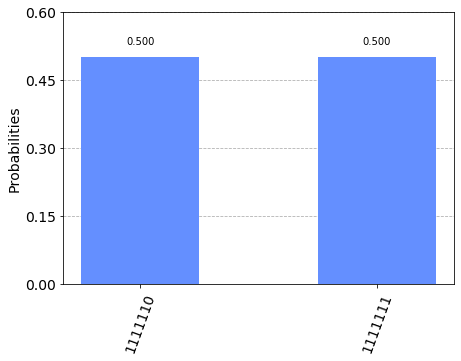

In [48]:
plot_histogram(count)

In [49]:
circuit.draw(fold=-1)

┌───┐┌───┐┌─────────────────────────┐             ┌─────────────────────────┐             ┌─────────────────────────┐             ┌─────────────────────────┐             ┌──────────────────────────┐             ┌──────────────────────────┐             ┌──────────────────────────┐                      
q141_0: ┤ X ├┤ H ├┤0                        ├─────────────┤0                        ├─────────────┤0                        ├─────────────┤0                        ├─────────────┤0                         ├─────────────┤0                         ├─────────────┤0                         ├──────────────────────
        ├───┤└───┘│  Controlled-Evolution^1 │┌───────────┐│                         │             │                         │             │                         │             │                          │             │                          │             │                          │             ┌───────┐
q142_0: ┤ H ├─────┤1                        ├┤ P(4.6756) ├┤  Controlled-Evolution^2 ├─────────────┤                         ├─────────────┤                         ├─────────────┤                          ├─────────────┤                          ├─────────────┤                          ├─────────────┤0      ├
        ├───┤     └─────────────────────────┘└───────────┘│                         │┌───────────┐│  Controlled-Evolution^4 │             │                         │             │                          │             │                          │             │                          │             │       │
q142_1: ┤ H ├─────────────────────────────────────────────┤1                        ├┤ P(9.3511) ├┤                         ├─────────────┤  Controlled-Evolution^8 ├─────────────┤                          ├─────────────┤                          ├─────────────┤                          ├─────────────┤1      ├
        ├───┤                                             └─────────────────────────┘└───────────┘│                         │┌───────────┐│                         │             │  Controlled-Evolution^16 │             │                          │             │                          │             │       │
q142_2: ┤ H ├─────────────────────────────────────────────────────────────────────────────────────┤1                        ├┤ P(18.702) ├┤                         ├─────────────┤                          ├─────────────┤  Controlled-Evolution^32 ├─────────────┤                          ├─────────────┤2      ├
        ├───┤                                                                                     └─────────────────────────┘└───────────┘│                         │┌───────────┐│                          │             │                          │             │  Controlled-Evolution^64 │             │       │
q142_3: ┤ H ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1                        ├┤ P(37.405) ├┤                          ├─────────────┤                          ├─────────────┤                          ├─────────────┤3 iqft ├
        ├───┤                                                                                                                             └─────────────────────────┘└───────────┘│                          │┌───────────┐│                          │             │                          │             │       │
q142_4: ┤ H ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1                         ├┤ P(74.809) ├┤                          ├─────────────┤                          ├─────────────┤4      ├
        ├───┤                                                                                                                                                                     └──────────────────────────┘└───────────┘│                          │┌───────────┐│               

In [50]:
A=[[1,-1/2],[-1/2,1]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)

Matrix:
 [[1, -0.5], [-0.5, 1]] 

Expected Eigen Values: [1.5 0.5]

Counts: {'11': 0.500000000000001, '10': 0.500000000000001}

Actual Eigen Value from Circuit:
Binary: 11  Corresponding Eigen Value: 1.5
Binary: 10  Corresponding Eigen Value: 0.5


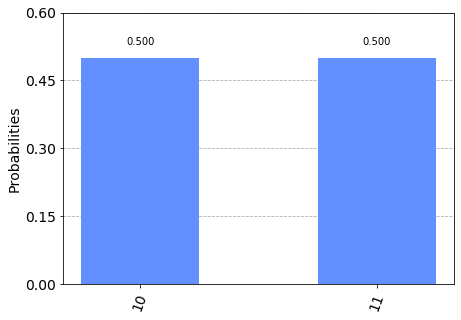

In [51]:
plot_histogram(count)

In [52]:
circuit.draw(fold=-1)

┌───┐┌───┐┌─────────────────────────┐        ┌─────────────────────────┐                  
q162_0: ┤ X ├┤ H ├┤0                        ├────────┤0                        ├──────────────────
        ├───┤└───┘│  Controlled-Evolution^1 │┌──────┐│                         │         ┌───────┐
q163_0: ┤ H ├─────┤1                        ├┤ P(π) ├┤  Controlled-Evolution^2 ├─────────┤0      ├
        ├───┤     └─────────────────────────┘└──────┘│                         │┌───────┐│  iqft │
q163_1: ┤ H ├────────────────────────────────────────┤1                        ├┤ P(2π) ├┤1      ├
        └───┘                                        └─────────────────────────┘└───────┘└───────┘

In [53]:
A = [[1.5, 0.5], [0.5, 1.5]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)

Matrix:
 [[1.5, 0.5], [0.5, 1.5]] 

Expected Eigen Values: [2. 1.]

Counts: {'11': 0.036611652351682, '10': 0.036611652351682, '01': 0.036611652351682, '00': 0.036611652351682}

Actual Eigen Value from Circuit:
Binary: 11  Corresponding Eigen Value: 2.0
Binary: 10  Corresponding Eigen Value: 0.6666666666666666
Binary: 01  Corresponding Eigen Value: 1.3333333333333333
Binary: 00  Corresponding Eigen Value: 0.0


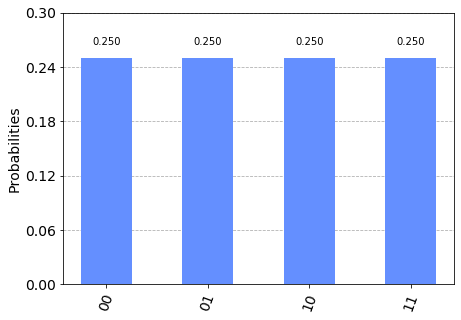

In [54]:
plot_histogram(count)

In [55]:
A = [[1, 1], [0, 2]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)

Matrix:
 [[1, 1], [0, 2]] 

Expected Eigen Values: [1. 2.]

Counts: {'00': 0.03125, '01': 0.005361652351682, '11': 0.005361652351682, '10': 0.016084957055045}

Actual Eigen Value from Circuit:
Binary: 00  Corresponding Eigen Value: 0.0
Binary: 01  Corresponding Eigen Value: 2.0
Binary: 11  Corresponding Eigen Value: 3.0
Binary: 10  Corresponding Eigen Value: 1.0


In [56]:
A = [[1.5, 0], [0, 0.5]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)

Matrix:
 [[1.5, 0], [0, 0.5]] 

Expected Eigen Values: [1.5 0.5]

Counts: {'10': 0.5, '01': 0.5}

Actual Eigen Value from Circuit:
Binary: 10  Corresponding Eigen Value: 0.5
Binary: 01  Corresponding Eigen Value: 1.0


In [57]:
A = [[1, -0.5], [-0.5, 1]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)

Matrix:
 [[1, -0.5], [-0.5, 1]] 

Expected Eigen Values: [1.5 0.5]

Counts: {'11': 0.500000000000001, '10': 0.500000000000001}

Actual Eigen Value from Circuit:
Binary: 11  Corresponding Eigen Value: 1.5
Binary: 10  Corresponding Eigen Value: 0.5


In [58]:
A = [[0.69, 0.49], [0.49, 0.92]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=3,negativeEigen=False)

Matrix:
 [[0.69, 0.49], [0.49, 0.92]] 

Expected Eigen Values: [0.30168598 1.30831402]

Counts: {'101': 0.023635946863532, '100': 0.025764378057297, '001': 0.029359074130578, '000': 0.01045216143069, '110': 0.003574353083768, '111': 0.005822658642364, '010': 0.012212043999822, '011': 0.004488579357237}

Actual Eigen Value from Circuit:
Binary: 101  Corresponding Eigen Value: 1.0071428571428571
Binary: 100  Corresponding Eigen Value: 0.20142857142857143
Binary: 001  Corresponding Eigen Value: 0.8057142857142857
Binary: 000  Corresponding Eigen Value: 0.0
Binary: 110  Corresponding Eigen Value: 0.6042857142857142
Binary: 111  Corresponding Eigen Value: 1.41
Binary: 010  Corresponding Eigen Value: 0.40285714285714286
Binary: 011  Corresponding Eigen Value: 1.2085714285714284


## QPE for finite difference matrix 2*2

Matrix:
 [[2, -1], [-1, 2]] 

Expected Eigen Values: [3. 1.]

Counts: {'11': 0.500000000000001, '10': 0.500000000000001}

Actual Eigen Value from Circuit:
Binary: 11  Corresponding Eigen Value: 3.0
Binary: 10  Corresponding Eigen Value: 1.0


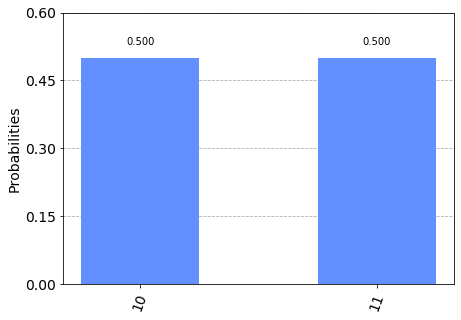

In [60]:
A = [[2, -1], [-1, 2]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)
plot_histogram(count)